In [1]:
import pandas as pd 
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [2]:
onefamadult = 'onefamadult.csv'
onefamadult = pd.read_csv(onefamadult)

In [3]:
onefamadult = onefamadult.astype('int64')

In [4]:
import sklearn
from sklearn.ensemble import AdaBoostClassifier,ExtraTreesClassifier,RandomForestClassifier,VotingClassifier
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import learning_curve,train_test_split
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from pycaret.classification import *
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb 

In [5]:
# scale 하면 오히려 안됨 ;;; 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
subset = onefamadult[['AGE_P', 'BMI', 'ASISLEEP']]
# StandardScaler 객체 생성
scaler = MinMaxScaler()
# 선택한 열에 대해 스케일링 적용
scaled_subset = scaler.fit_transform(subset)
# 스케일링된 데이터를 원래의 데이터프레임에 덮어쓰기
onefamadult[['AGE_P', 'BMI', 'ASISLEEP']] = scaled_subset

In [6]:
import pycaret

print(pycaret.__version__)

3.2.0


In [15]:
clf = setup(data=onefamadult, target='DIBEV1', train_size=0.8, fix_imbalance=True) 

# compare_models 함수로 여러 모델을 학습하고 최적의 모델을 반환합니다.
# best_model = compare_models(n_select=1, sort='recall', verbose=True, exclude=['lightgbm'])
best_model = create_model('nb')
tuned_model = tune_model(best_model)
print(best_model)
tuned_model
# 최적의 모델
# tuned_model = tune_model(best_model, verbose=True)

,Description,Value
0,Session id,4470
1,Target,DIBEV1
2,Target type,Binary
3,Target mapping,"1: 0, 2: 1"
4,Original data shape,"(25417, 204)"
5,Transformed data shape,"(39866, 204)"
6,Transformed train set shape,"(34782, 204)"
7,Transformed test set shape,"(5084, 204)"
8,Numeric features,203
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.1613,0.7768,0.1613,0.8124,0.0723,0.0033,0.0280
1,0.1642,0.7631,0.1642,0.8034,0.0782,0.0033,0.0262
2,0.1603,0.7658,0.1603,0.7430,0.0730,-0.0006,-0.0045
3,0.1618,0.7637,0.1618,0.7969,0.0742,0.0026,0.0216
4,0.1574,0.7591,0.1574,0.7575,0.0664,0.0002,0.0022
5,0.1618,0.7345,0.1618,0.7814,0.0750,0.0018,0.0143
6,0.1604,0.7845,0.1604,0.8290,0.0696,0.0037,0.0340
7,0.1623,0.7583,0.1623,0.7987,0.0751,0.0028,0.0227
8,0.1574,0.7600,0.1574,0.7412,0.0672,-0.0006,-0.0052


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7404,0.7863,0.7404,0.8327,0.7722,0.2658,0.2933
1,0.7738,0.7698,0.7738,0.8294,0.7951,0.2837,0.2976
2,0.7719,0.7718,0.7719,0.8260,0.7929,0.2726,0.2853
3,0.7555,0.7792,0.7555,0.8406,0.7846,0.2970,0.3250
4,0.7723,0.7602,0.7723,0.8257,0.7931,0.2702,0.2825
5,0.7673,0.7420,0.7673,0.8141,0.7865,0.2321,0.2403
6,0.7555,0.7947,0.7555,0.8365,0.7839,0.2870,0.3119
7,0.7250,0.7654,0.7250,0.8284,0.7602,0.2442,0.2735
8,0.7177,0.7624,0.7177,0.8360,0.7557,0.2561,0.2938


Fitting 10 folds for each of 10 candidates, totalling 100 fits
GaussianNB(priors=None, var_smoothing=1e-09)


GaussianNB(priors=None, var_smoothing=0.01)

In [8]:
x_train,x_test,y_train,y_test = train_test_split(onefamadult.drop('DIBEV1', axis=1), onefamadult['DIBEV1'],train_size=0.8)

smote = SMOTE(random_state=42)

x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3818, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, force_row_wise=True)

model.fit(x_resampled,y_resampled)
y_pred = model.predict(x_test)

precision_1 = precision_score(y_test, y_pred, pos_label=1.0)
recall_1 = recall_score(y_test, y_pred, pos_label=1.0)
f1_1 = f1_score(y_test, y_pred, pos_label=1.0)

# 라벨 2.0에 대한 정밀도, 재현율, F1 스코어 계산
precision_2 = precision_score(y_test, y_pred, pos_label=2.0)
recall_2 = recall_score(y_test, y_pred, pos_label=2.0)
f1_2 = f1_score(y_test, y_pred, pos_label=2.0)

# 결과 출력
print(f"Precision 라벨 1.0: {precision_1:.4f}")
print(f"Recall 라벨 1.0: {recall_1:.4f}")
print(f"F1 Score 라벨 1.0: {f1_1:.4f}")

print(f"\nPrecision 라벨 2.0: {precision_2:.4f}")
print(f"Recall 라벨 2.0: {recall_2:.4f}")
print(f"F1 Score 라벨 2.0: {f1_2:.4f}")

[LightGBM] [Info] Number of positive: 17379, number of negative: 17379
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 34758, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Precision 라벨 1.0: 0.5865
Recall 라벨 1.0: 0.3375
F1 Score 라벨 1.0: 0.4284

Precision 라벨 2.0: 0.8974
Recall 라벨 2.0: 0.9606
F1 Score 라벨 2.0: 0.9279


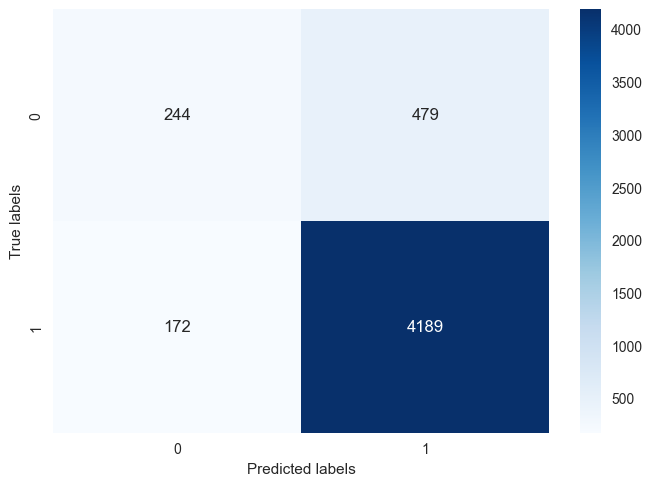

In [9]:
# CONFUSION MATRIX 그리는법 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 2780
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 2780, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Lig

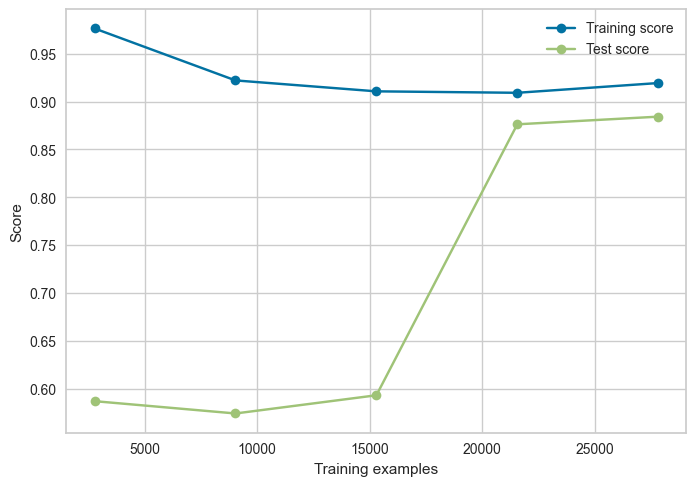

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, x_resampled, y_resampled, cv=None, train_sizes=np.linspace(0.1, 1.0, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Test score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

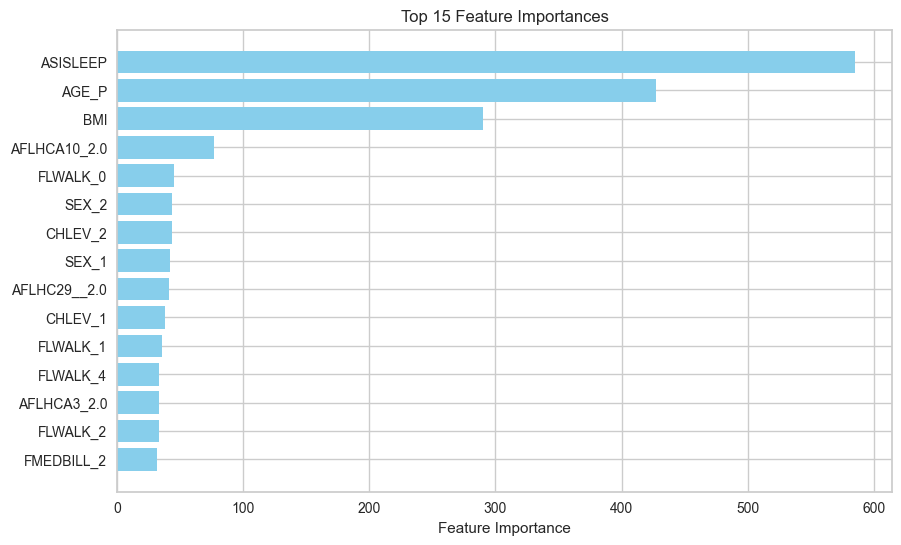

In [11]:
import matplotlib.pyplot as plt

# feature_importances_를 내림차순으로 정렬하고 상위 15개를 선택합니다.
sorted_idx = model.feature_importances_.argsort()[::-1][:15]
top_features = [model.feature_name_[i] for i in sorted_idx]
top_importances = model.feature_importances_[sorted_idx]

# 상위 15개의 특성과 중요도 값을 사용하여 막대 그래프를 그립니다.
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()  # 상위 15개의 특성이 위에 위치하도록 y축을 뒤집습니다.
plt.show()

## MultinomialNB

In [12]:
x_train,x_test,y_train,y_test = train_test_split(onefamadult.drop('DIBEV1', axis=1), onefamadult['DIBEV1'],train_size=0.8)

smote = SMOTE(random_state=42)

x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

model = MultinomialNB()

model.fit(x_resampled,y_resampled)
y_pred = model.predict(x_test)

precision_1 = precision_score(y_test, y_pred, pos_label=1.0)
recall_1 = recall_score(y_test, y_pred, pos_label=1.0)
f1_1 = f1_score(y_test, y_pred, pos_label=1.0)

# 라벨 2.0에 대한 정밀도, 재현율, F1 스코어 계산
precision_2 = precision_score(y_test, y_pred, pos_label=2.0)
recall_2 = recall_score(y_test, y_pred, pos_label=2.0)
f1_2 = f1_score(y_test, y_pred, pos_label=2.0)

# 결과 출력
print(f"Precision 라벨 1.0: {precision_1:.4f}")
print(f"Recall 라벨 1.0: {recall_1:.4f}")
print(f"F1 Score 라벨 1.0: {f1_1:.4f}")

print(f"\nPrecision 라벨 2.0: {precision_2:.4f}")
print(f"Recall 라벨 2.0: {recall_2:.4f}")
print(f"F1 Score 라벨 2.0: {f1_2:.4f}")

Precision 라벨 1.0: 0.3213
Recall 라벨 1.0: 0.6979
F1 Score 라벨 1.0: 0.4401

Precision 라벨 2.0: 0.9321
Recall 라벨 2.0: 0.7377
F1 Score 라벨 2.0: 0.8236


In [17]:
from sklearn.naive_bayes import GaussianNB
x_train,x_test,y_train,y_test = train_test_split(onefamadult.drop('DIBEV1', axis=1), onefamadult['DIBEV1'],train_size=0.8)

smote = SMOTE(random_state=42)

x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

model = GaussianNB(priors=None, var_smoothing=0.01)

model.fit(x_resampled,y_resampled)
y_pred = model.predict(x_test)

precision_1 = precision_score(y_test, y_pred, pos_label=1.0)
recall_1 = recall_score(y_test, y_pred, pos_label=1.0)
f1_1 = f1_score(y_test, y_pred, pos_label=1.0)

# 라벨 2.0에 대한 정밀도, 재현율, F1 스코어 계산
precision_2 = precision_score(y_test, y_pred, pos_label=2.0)
recall_2 = recall_score(y_test, y_pred, pos_label=2.0)
f1_2 = f1_score(y_test, y_pred, pos_label=2.0)

# 결과 출력
print(f"Precision 라벨 1.0: {precision_1:.4f}")
print(f"Recall 라벨 1.0: {recall_1:.4f}")
print(f"F1 Score 라벨 1.0: {f1_1:.4f}")

print(f"\nPrecision 라벨 2.0: {precision_2:.4f}")
print(f"Recall 라벨 2.0: {recall_2:.4f}")
print(f"F1 Score 라벨 2.0: {f1_2:.4f}")

Precision 라벨 1.0: 0.3201
Recall 라벨 1.0: 0.5382
F1 Score 라벨 1.0: 0.4015

Precision 라벨 2.0: 0.9143
Recall 라벨 2.0: 0.8117
F1 Score 라벨 2.0: 0.8600
